<a href="https://colab.research.google.com/github/riddhimajain938/NYU---Data-Bootcamp---Midterm/blob/main/Midterm_Data_Bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Bootcamp Midterm Project  


---


## Exploring the Economic Forces Driving the U.S. Housing Market  
<p> By: Pia Jain, Lunamia Bolanos, and Dhwani Agarwal </p>

<p>
  <img src="https://img.freepik.com/free-vector/real-estate-deals-agent-client-shaking-hands-people-buying-building-houses-market-growth-flat-vector-illustration-investment-construction-rent-property-concept_74855-22534.jpg" width="300">
</p>



In [ ]:
#imports
import seaborn as sns
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import requests
import statsmodels.api as sm


api_key = "94a2ca6851bbcffc767a6235250c1d16"
start_date = "2015-01-01"
end_date = "2025-10-18"

#defines a func to get the fred data
def get_fred(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])

    #changes data type
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    #changes index
    df = df.set_index('date')[['value']].rename(columns={'value': series_id})

    return df


Looking for generic patterns between the real estate stocks:

/tmp/ipython-input-4204208867.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end=None)
[*********************100%***********************]  5 of 5 completed


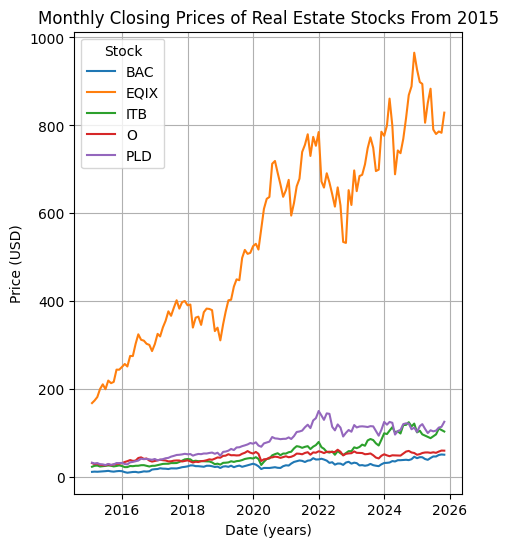

In [ ]:
#uploading yfinance stock data for pop real estate stocks
tickers = ["ITB", "PLD", "BAC", "EQIX", "O"]
data = yf.download(tickers, start="2015-01-01", end=None)

# isolating the close data
close_data = data["Close"].copy()

# resample to monthly
mon_data = close_data.resample("ME").last()

#making a cute chart of the stock prices ONLY
plt.figure(figsize=(5,6))
plt.plot(mon_data)
plt.title("Monthly Closing Prices of Real Estate Stocks From 2015")
plt.xlabel("Date (years)")
plt.ylabel("Price (USD)")
plt.legend(mon_data.columns, title="Stock")
plt.grid(True)
plt.show()


Looking for generic patterns between the macroeconomics indicators:

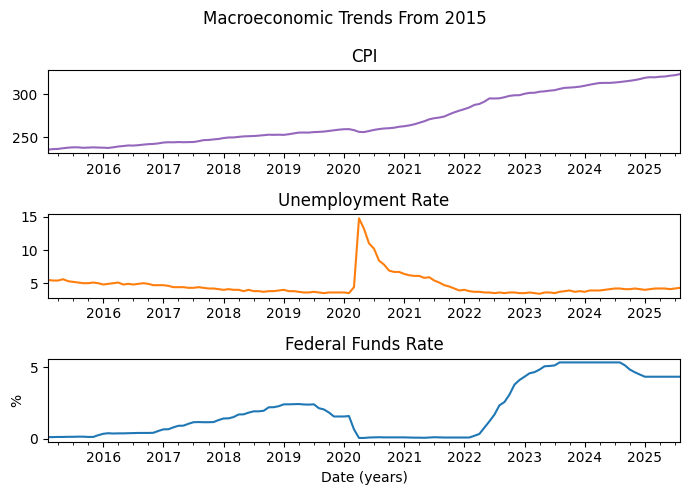

In [ ]:
#calling func to get unemployment, CPI, and interest rate
cpi = get_fred("CPIAUCSL", api_key, start_date, end_date)
unempl = get_fred("UNRATE", api_key, start_date, end_date)
fedfunds = get_fred("FEDFUNDS", api_key, start_date, end_date)

#resample them monthly to match yfinanace
cpi_m = cpi.resample("ME").last()
unempl_m = unempl.resample("ME").last()
fedfunds_m = fedfunds.resample("ME").last()

#takes last day of each month stock prices
mon_prices = close_data.resample("ME").last()

#showing percent change (how each stock grew or fell each month)
mon_returns = mon_prices.pct_change().dropna()

#combine this with the FRED data
joined = mon_returns.join([cpi_m, unempl_m, fedfunds_m], how="inner").dropna()


#graph of FRED data
fig, ax = plt.subplots(3, 1, figsize=(7, 5))
plt.xlabel("Date (years)")
plt.ylabel("%")

joined['CPIAUCSL'].plot(ax=ax[0], color='tab:purple')
ax[0].set_title("CPI")

joined['UNRATE'].plot(ax=ax[1], color='tab:orange')
ax[1].set_title("Unemployment Rate")

joined['FEDFUNDS'].plot(ax=ax[2], color='tab:blue')
ax[2].set_title("Federal Funds Rate")

fig.suptitle("Macroeconomic Trends From 2015")
plt.tight_layout()

We wanted to investigate how real estate stocks respond to macroeconomic data (unemployment rate, CPI, inflation) and which REIT sectors are more interest-rate sensitive vs inflation resilient. so first we plotted both data sets seperately to see if anything was apparent immediately.  

Interpretation of graphs:
- EQIX shows highest price level and volatility. so tevh driven nature of data center real estate.
- LD and O are prtty stable bc retail REITS's are steady
ITB mirros macro housing trends rising during the 2020-2021 housing boom
- BAC is standard

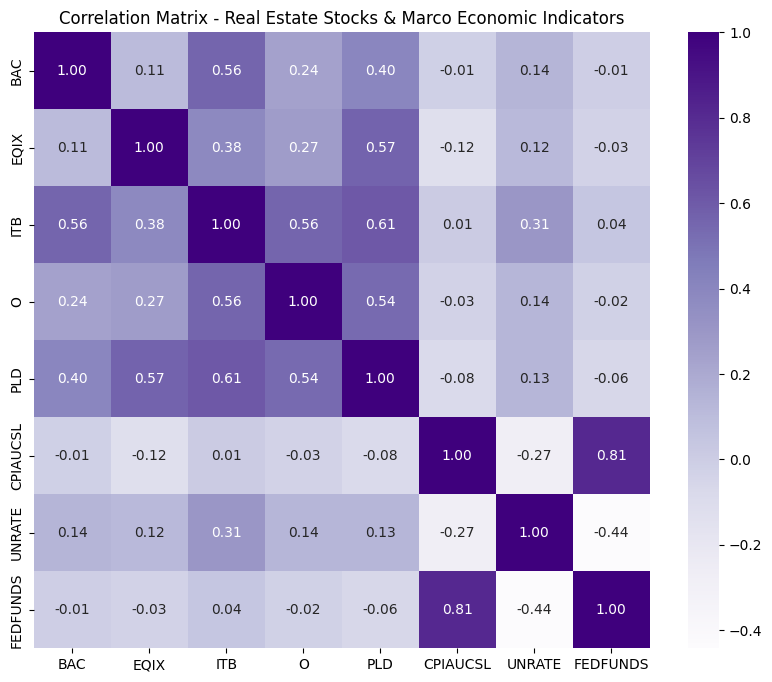

               BAC      EQIX       ITB         O       PLD  CPIAUCSL  \
BAC       1.000000  0.106659  0.555097  0.243818  0.402349 -0.014989   
EQIX      0.106659  1.000000  0.384579  0.268533  0.565432 -0.124270   
ITB       0.555097  0.384579  1.000000  0.559029  0.609473  0.012643   
O         0.243818  0.268533  0.559029  1.000000  0.536734 -0.033769   
PLD       0.402349  0.565432  0.609473  0.536734  1.000000 -0.079288   
CPIAUCSL -0.014989 -0.124270  0.012643 -0.033769 -0.079288  1.000000   
UNRATE    0.138450  0.117783  0.305658  0.135123  0.133660 -0.271041   
FEDFUNDS -0.007841 -0.033018  0.043137 -0.023898 -0.064445  0.811473   

            UNRATE  FEDFUNDS  
BAC       0.138450 -0.007841  
EQIX      0.117783 -0.033018  
ITB       0.305658  0.043137  
O         0.135123 -0.023898  
PLD       0.133660 -0.064445  
CPIAUCSL -0.271041  0.811473  
UNRATE    1.000000 -0.442136  
FEDFUNDS -0.442136  1.000000  


In [ ]:
#correlation matrix
corr_matrix = joined.corr()

# create a heatmap of the corr matrix to better visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True,cmap="Purples", fmt=".2f", square=True)
plt.title("Correlation Matrix - Real Estate Stocks & Marco Economic Indicators")
plt.show()
print(corr_matrix)


Correlation Matrix: very very slight correlation between the macro indicators and stock prices (very different from our orginial predictions)

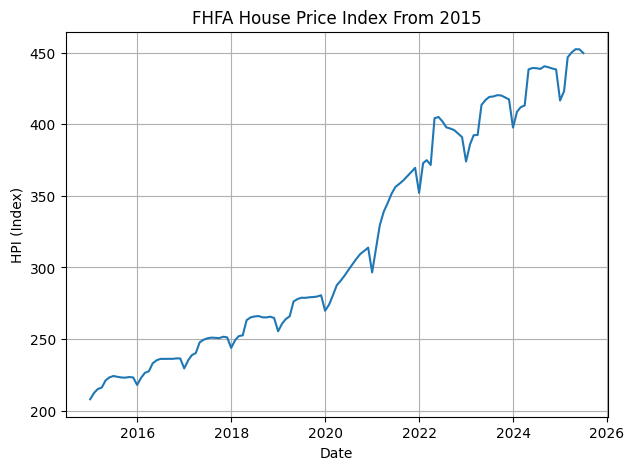

In [ ]:
#getting the housing data!
url = "http://fhfa.gov/hpi/download/monthly/hpi_master.json"
data = requests.get(url).json()

#making it the right datatype
housing_data = pd.DataFrame(data)
housing_data['index_nsa'] = housing_data['index_nsa'].astype(float)
housing_data['yr'] = housing_data['yr'].astype(int)
housing_data['period'] = housing_data['period'].astype(int)

#averaging the regional indices of each year and month and combining into a
#single date column from 2015 - now
mon_avg = housing_data.groupby(['yr', 'period'])['index_nsa'].mean().reset_index()
mon_avg['date'] = pd.to_datetime(mon_avg['yr'].astype(str) + '-' +
                                 mon_avg['period'].astype(str) + '-01')
mon_avg = mon_avg[mon_avg['date'] >= '2015-01-01']
mon_avg = mon_avg.set_index('date')

#housing data simple overall graph
plt.figure(figsize=(7,5))
plt.plot(mon_avg.index, mon_avg['index_nsa'])
plt.title('FHFA House Price Index From 2015')
plt.xlabel('Date')
plt.ylabel('HPI (Index)')
plt.grid(True)
plt.show()

^^Trying to new another variable that is correlated with these macro indicators like the FHFA house price index

In [ ]:
#grouping FHFA data by year and month with the mean of index_nsa
mon_avg = (housing_data.groupby(["yr", "period"])["index_nsa"].mean().reset_index())
#combining the year and month to form a date string. then convert numbers to strings
#make sure its a pandas datetime
mon_avg["date"] = pd.to_datetime(mon_avg["yr"].astype(str) + "-" + mon_avg["period"].astype(str).str.zfill(2) + "-01")
mon_avg["date"] = mon_avg["date"] + pd.offsets.MonthEnd(0)
mon_avg = mon_avg.set_index("date")[["index_nsa"]]
mon_avg = mon_avg["2020-01-01":]

#ALL merged data of yfinanace, FRED and housing
joined = mon_returns.join([cpi_m, unempl_m, fedfunds_m, mon_avg], how="outer").dropna()

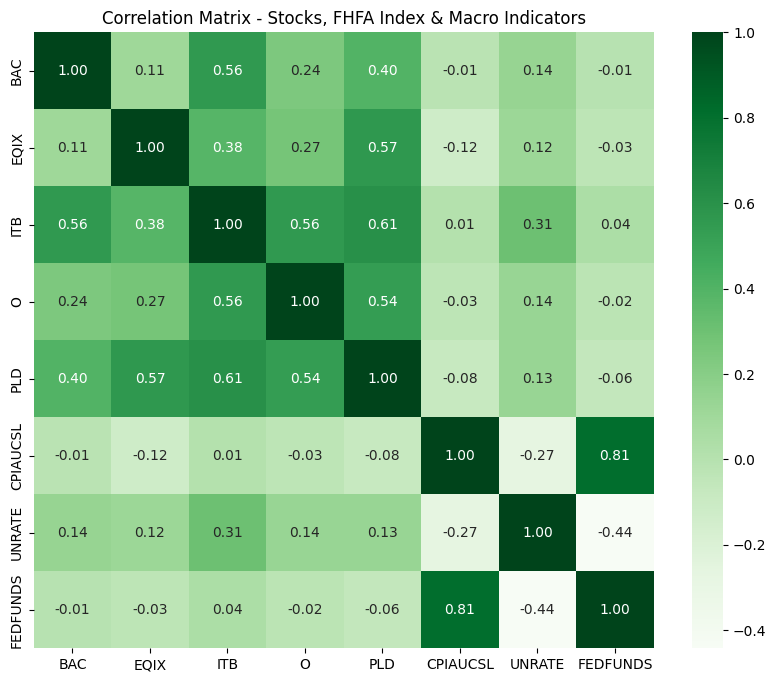

In [ ]:
#correlation map now WITH the housing data

corr_matrix = joined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Greens", fmt=".2f",)
plt.title("Correlation Matrix - Stocks, FHFA Index & Macro Indicators")
plt.show()

^^Correlation matrix interpreation
HPI and CPI very strong correlation (.97) so housing prices rise closely with inflation
HPI and unemployment have a negative relationship (-.67) housing tends to strengthen when labor market is strong.

Basically. there is no short term alignment but rather long term structural relationships between housing, inflation, and rates.


We are now doing one final analysis: we now use a linear regression model to quantify how macroeconomic factors — inflation (CPI), unemployment (UNRATE), and interest rates (FEDFUNDS) — influence real estate stock performance.

We focus on PLD (Prologis), a major logistics REIT, as our dependent variable, since it represents a stable segment of the real estate sector.

                            OLS Regression Results                            
Dep. Variable:              index_nsa   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     272.3
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           2.02e-28
Time:                        19:10:17   Log-Likelihood:                -181.04
No. Observations:                  48   AIC:                             370.1
Df Residuals:                      44   BIC:                             377.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -568.3379     57.209     -9.934      0.0

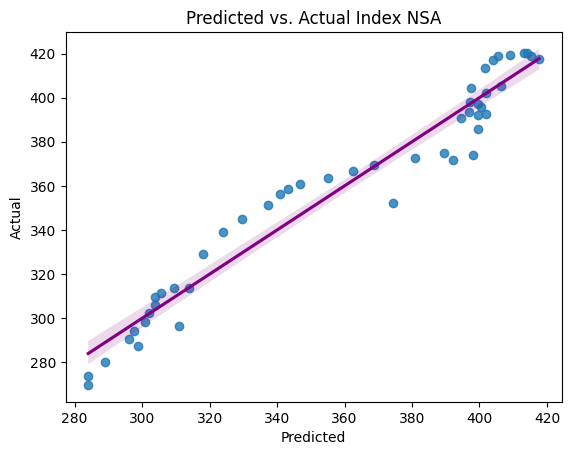

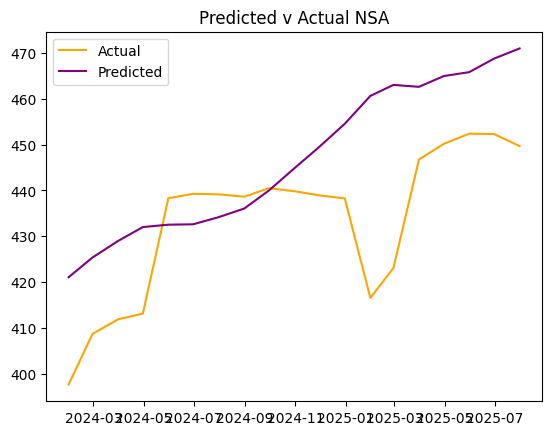

In [ ]:
#assigns x and y for regression

X = joined[['CPIAUCSL', 'UNRATE', 'FEDFUNDS']]
y = joined['index_nsa']
X = sm.add_constant(X)

#trains data until 2023, tests the data from 2024-pres
train = X.loc[:'2023']
test = X.loc['2024':]
y_train = y.loc[:'2023']
y_test = y.loc['2024':]

#models the data and prints
model = sm.OLS(y_train, train).fit()
print(model.summary())

#makes the regg plot using SNS
sns.regplot(x=model.fittedvalues, y=y_train, line_kws={'color': 'purple'})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs. Actual Index NSA")
plt.show()

#plot to show how well the model predicts
y_pred = model.predict(test)
plt.plot(y_test.index, y_test, label='Actual', color='orange')
plt.plot(y_test.index, y_pred, label='Predicted', color='purple')
plt.title("Predicted v Actual NSA")
plt.legend()
plt.show()

When we fit our linear regression model to HPI- it explained through
the r-squared value (.94) that approximately 95% of variance in the HPI is through
a strong linear relationship between macroeconomic variables (unemployment etc)

We don't want to disregard our predictive model because it does capture the
long term upward trend but it doesn't consier short-tern fluctuations. We came to this conclusion before after the second correlation matrix.

                            OLS Regression Results                            
Dep. Variable:                    PLD   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.5347
Date:                Wed, 22 Oct 2025   Prob (F-statistic):              0.711
Time:                        19:17:33   Log-Likelihood:                 52.510
No. Observations:                  48   AIC:                            -95.02
Df Residuals:                      43   BIC:                            -85.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2763      0.803     -0.344      0.7

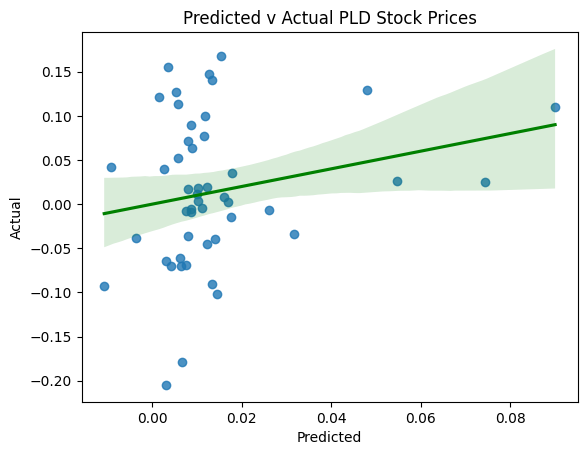

In [ ]:
#confirming that there is weak correlation between stock prices and macro data.
# so we chose the least volatile stock to examine

#gets the variables
y = joined['PLD']
X = joined[['index_nsa', 'CPIAUCSL', 'UNRATE', 'FEDFUNDS']]

# add constant term
X = sm.add_constant(X)

#trains data until 2023, tests the data from 2024-pres
train = X.loc[:'2023']
test = X.loc['2024':]
y_train = y.loc[:'2023']
y_test = y.loc['2024':]

# fit regression model
model2 = sm.OLS(y_train, train).fit()
print(model2.summary())

#makes the reg plot
sns.regplot(x=model2.fittedvalues, y=y_train, line_kws={'color': 'green'})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted v Actual PLD Stock Prices")
plt.show()

This graph confirms what we found before that there is low correlation between stock prices and macro data.
there is a very low R² of 0.056, indicating that these variables explain less than 6% of the variation in monthly stock movements.

IMPORTANT CONCLUSION: The weak fit also reflects the higher volatility and
forward-looking nature of public markets compared to the slow-moving
fundamentals of housing prices.